In [87]:
import pandas as pd
from data_cleaning import rows_to_remove
from data_cleaning import print_missing
from data_cleaning import plot_heatmap

In [88]:
df = pd.read_csv("cleaned.csv")
print("old columns")
print(df.columns)
df.drop('Unnamed: 0',axis = 1, inplace=True)

print("new columns")
print(df.columns)

old columns
Index(['Unnamed: 0', 'major_city', 'state', 'lat', 'lon', 'technology',
       'race_perc_non_white', 'ppl_per_sq_mile', 'n_providers',
       'internet_perc_broadband', 'median_household_income',
       'city_household_income', 'deal'],
      dtype='object')
new columns
Index(['major_city', 'state', 'lat', 'lon', 'technology',
       'race_perc_non_white', 'ppl_per_sq_mile', 'n_providers',
       'internet_perc_broadband', 'median_household_income',
       'city_household_income', 'deal'],
      dtype='object')


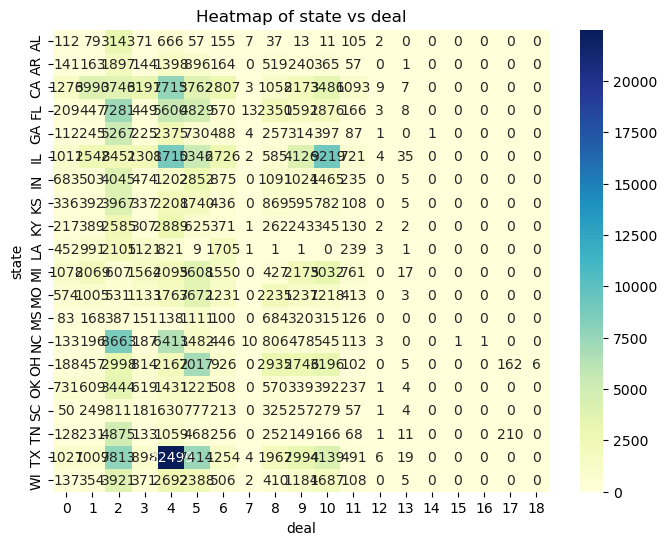

In [89]:
plot_heatmap(df,"state","deal")

In [90]:
df_copy = df.copy()

df_copy.drop("major_city", axis=1 ,inplace=True)



In [91]:
# One-hot encode the 'technology', 'state', and 'major_city' columns
encoded_cols = pd.get_dummies(df_copy[['technology', 'state']], dtype='uint8')

# Merge the encoded columns with the original DataFrame copy
df_merged = pd.concat([df_copy, encoded_cols], axis=1)

# Drop the original 'technology', 'state', and 'major_city' columns
df_merged.drop(['technology', 'state'], axis=1, inplace=True)

print(df_merged.columns)

Index(['lat', 'lon', 'race_perc_non_white', 'ppl_per_sq_mile', 'n_providers',
       'internet_perc_broadband', 'median_household_income',
       'city_household_income', 'deal', 'technology_Fiber',
       'technology_Not Fiber', 'state_AL', 'state_AR', 'state_CA', 'state_FL',
       'state_GA', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA',
       'state_MI', 'state_MO', 'state_MS', 'state_NC', 'state_OH', 'state_OK',
       'state_SC', 'state_TN', 'state_TX', 'state_WI'],
      dtype='object')


In [92]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [93]:
min_scaler = MinMaxScaler()

columns_to_scale = ['lat','lon','median_household_income','city_household_income']
df_merged[columns_to_scale] = min_scaler.fit_transform(df[columns_to_scale])

In [94]:
df_merged_copy = df_merged.copy()

In [95]:
y = df_merged['deal'].values

# Create X containing everything else except 'deal'
X = df_merged.drop('deal', axis=1).values

print("X array:")
print(X)
print("\ny array:")
print(y)

X array:
[[0.38092285 0.82476639 0.47505938 ... 0.         0.         0.        ]
 [0.38109753 0.82475774 0.47505938 ... 0.         0.         0.        ]
 [0.38101996 0.82479025 0.47505938 ... 0.         0.         0.        ]
 ...
 [0.98818259 0.78848011 0.14503817 ... 0.         0.         1.        ]
 [0.98832745 0.78837171 0.14503817 ... 0.         0.         1.        ]
 [0.98810283 0.78834706 0.14503817 ... 0.         0.         1.        ]]

y array:
[0 1 0 ... 4 5 4]


In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Assuming X and y are your input features and target variable
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define the MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(np.unique(y_train))
model = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [98]:
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

In [99]:
# Define your training function
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation
        model.eval()
        running_loss_valid = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for inputs_valid, targets_valid in valid_loader:
                outputs_valid = model(inputs_valid)
                loss_valid = criterion(outputs_valid, targets_valid)
                running_loss_valid += loss_valid.item()

                _, predicted_valid = torch.max(outputs_valid.data, 1)
                total_valid += targets_valid.size(0)
                correct_valid += (predicted_valid == targets_valid).sum().item()

        epoch_valid_loss = running_loss_valid / len(valid_loader)
        epoch_valid_accuracy = correct_valid / total_valid
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, '
              f'Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {epoch_valid_accuracy:.4f}')

    return train_accuracies, valid_accuracies

In [100]:
num_epochs = 100
ta, va = train_model(model, criterion, optimizer, train_loader,val_loader, num_epochs)

Epoch 1/100, Train Loss: 4.3887, Train Accuracy: 0.3312, Validation Loss: 2.6792, Validation Accuracy: 0.3794
Epoch 2/100, Train Loss: 2.4970, Train Accuracy: 0.3982, Validation Loss: 1.6416, Validation Accuracy: 0.4374
Epoch 3/100, Train Loss: 2.0377, Train Accuracy: 0.4172, Validation Loss: 2.1974, Validation Accuracy: 0.4248
Epoch 4/100, Train Loss: 1.6771, Train Accuracy: 0.4357, Validation Loss: 1.5380, Validation Accuracy: 0.4483
Epoch 5/100, Train Loss: 1.4798, Train Accuracy: 0.4475, Validation Loss: 1.4812, Validation Accuracy: 0.4265
Epoch 6/100, Train Loss: 1.4049, Train Accuracy: 0.4522, Validation Loss: 1.4119, Validation Accuracy: 0.4463
Epoch 7/100, Train Loss: 1.3844, Train Accuracy: 0.4522, Validation Loss: 1.4086, Validation Accuracy: 0.4494
Epoch 8/100, Train Loss: 1.3803, Train Accuracy: 0.4542, Validation Loss: 1.3673, Validation Accuracy: 0.4619
Epoch 9/100, Train Loss: 1.3784, Train Accuracy: 0.4561, Validation Loss: 1.4795, Validation Accuracy: 0.4271
Epoch 10/1

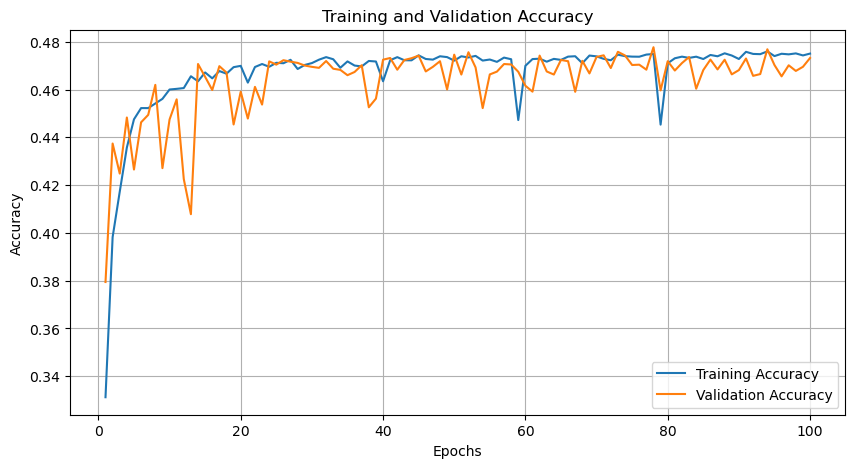

In [101]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), ta, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), va, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()